In [1]:
import cv2
from os import listdir
from os.path import isfile, join
import os, shutil
import numpy as np
import numpy as np
import cv2
from preprocessors import x_cord_contour, makeSquare, resize_to_pixel
from matplotlib import pyplot as plt

print(cv2.__version__)

4.4.0


In [2]:
def getContoursforNumbers(image, original):
    contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key = x_cord_contour, reverse = False)

    cv2.drawContours(original, contours, -1, (0,255,0), 3)
    print("Number of contours found = " + str(len(contours)))
    return contours, original

def x_cord_contour(contour):
    # This function take a contour from findContours
    # it then outputs the x centroid coordinates
    area = cv2.contourArea(contour)
    #print("area = " + str(area))
    if area > 10:
        M = cv2.moments(contour)
        if M['m00'] == 0.0:
            return 0
        else:
            x_center = int(M['m10']/M['m00'])
            return x_center
    else:
        return 0
    
def dynamic_threshold(image, k):
    try:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        gray_image = image
        pass

    kernel = np.ones((k,k), np.uint8)

    _, th2 = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((k,k), np.uint8)
    erode = cv2.erode(th2, kernel, iterations = 1)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(erode, kernel, iterations = 1)

    return dilation

def pre_process(image, kernal_blur = 5, erosion = 3):
    org = image.copy()
    # Blur is probably not necessary in most cases
    #im1 = cv2.GaussianBlur(image, (kernal_blur, kernal_blur), 0)

    im1 = dynamic_threshold(image, erosion) # Recommend 2
    #print("After Erosion")
    #plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
    #plt.show()
    contours, hierarchy = cv2.findContours(im1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key = x_cord_contour, reverse = False)

    #cv2.drawContours(org, contours, -1, (0,255,0), 1)
    #print("Number of contours found = " + str(len(contours)))

    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.show()

    all_area = [cv2.contourArea(c) for c in contours if(cv2.contourArea(c) > 20)]
    return contours, all_area, org, im1

def splitPlate(image):
    contours, all_area, org, th = pre_process(image)
    margin = int((th.shape[0] / 2) * 0.1)

    centerAxis = int(th.shape[0] / 2)
    lowerMargin = centerAxis - margin
    upperMargin = centerAxis + margin

    line_sums = []

    for i in range(21,31):
        line_sums.append(np.sum(th[i]))

    bestCenterLineIdx = np.argmin(line_sums) - margin + centerAxis
    
    split_plate = []
    top = image[0:bestCenterLineIdx, 0:image.shape[1]]
    split_plate.append(top)
    bottom = image[bestCenterLineIdx:centerAxis+bestCenterLineIdx, 0:image.shape[1]]
    split_plate.append(bottom)
    return split_plate

def imshow(image, title = ""):
    print(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
def apply_brightness_contrast(input_img, brightness = 0, contrast = 50):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf

def isBackgroundBlack(image, threshold = 0.4):
    if(len(image.shape) > 2): 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, th2 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  

    # Total if image was all white
    max_value_of_all_white = (th2.shape[0] * th2.shape[0]) * 255
    sum_of_LP = np.sum(th2)

    percent_of_white = max_value_of_all_white / sum_of_LP
    #print(percent_of_white)
    if percent_of_white < threshold:
        return False
    else:
        return True

def isPlateVertical(image):
    width = image.shape[0]
    height = image.shape[1]
    aspectRatio = width / float(height)
    vertical = aspectRatio > 0.5
    #print(aspectRatio)
    return vertical

In [3]:
subfolder = "./FINAL_PLATES/"
all_images = [subfolder+f for f in os.listdir(subfolder) if f.endswith(('.png','.jpg'))]
all_images

['./FINAL_PLATES/TCY9024_2fc9fe1a98c1cfc87a61a57d4e517812.png',
 './FINAL_PLATES/PDH2942_23cb16cb3a74421b252af2313efa32e7.png',
 './FINAL_PLATES/TCB8933_d67814491008ea8ee8db7379e34692b9.png',
 './FINAL_PLATES/PCP4971_aed52381c1e8a7a43f77d4f4262b13ca.png',
 './FINAL_PLATES/PCH2060_2fb39e6716344e6a3194aadecd7c0d14.png',
 './FINAL_PLATES/PBZ2808_fda2b90aee4332e042d5a7b90ed4d827.png',
 './FINAL_PLATES/HCX9433_6a1d921eab0f238d749e8b3b6bafc4b1.jpg',
 './FINAL_PLATES/PCT1880_8bf55726693807d3f731346b7eeebed4.png',
 './FINAL_PLATES/PBM10_5ffcf3c0b025d2b83e6acb0d353b5da0.png',
 './FINAL_PLATES/PDP7283_2e7a91ed020a1e6496d50bb56051e509.png',
 './FINAL_PLATES/PCL397_ed5b709eca03038214e39d8d2caa5bd4.png',
 './FINAL_PLATES/PDP1256_9eeaa2c387fb38eebdf5f405714112a8.png',
 './FINAL_PLATES/TDG6278_157247247503d40f33202c266a82ff7a.jpg',
 './FINAL_PLATES/TDN2284_1c9cfd45558625600a0debcb9f31339d.jpg',
 './FINAL_PLATES/PBP6949_8f27a249b66aea3350a3fe3db9c58c3f.png',
 './FINAL_PLATES/PCS6790_2bf6e6c89810d091e5

Original


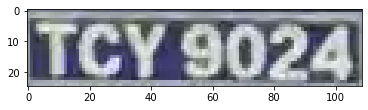

Plate is vertical: False
Plate is on black background: True


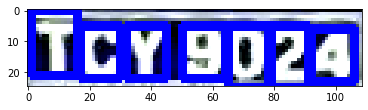

Original


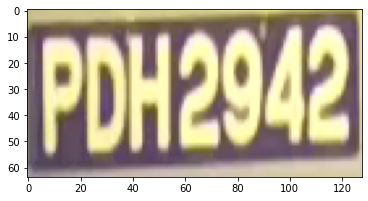

Plate is vertical: False
Plate is on black background: True


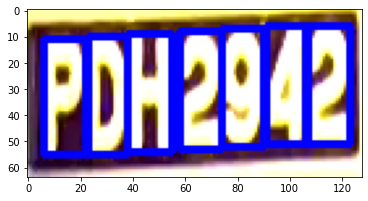

Original


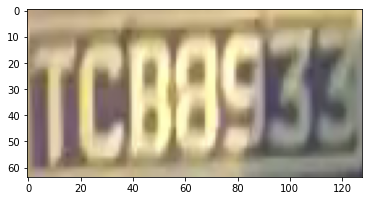

Plate is vertical: False
Plate is on black background: True


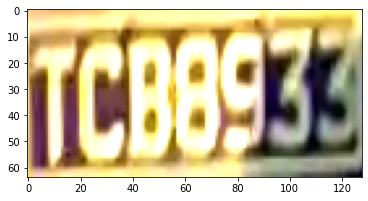

Original


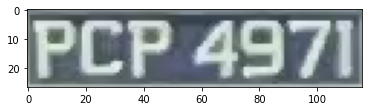

Plate is vertical: False
Plate is on black background: True


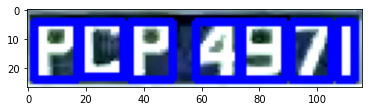

Original


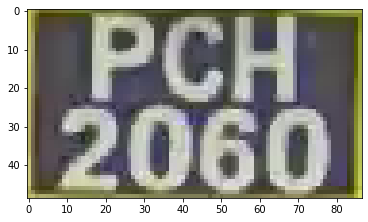

Plate is vertical: True
Plate is on black background: True


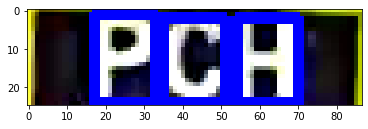

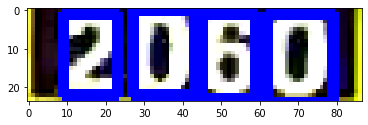

Original


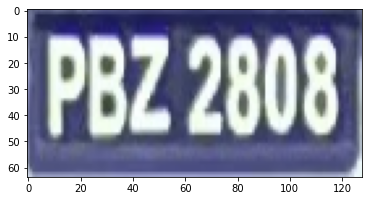

Plate is vertical: False
Plate is on black background: True


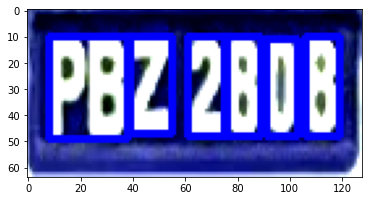

Original


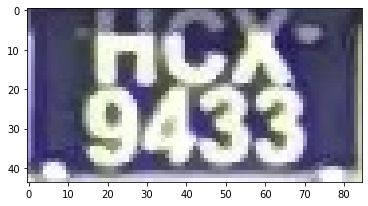

Plate is vertical: True
Plate is on black background: True


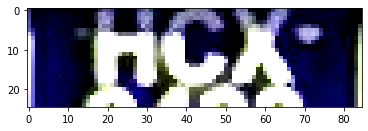

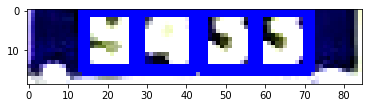

Original


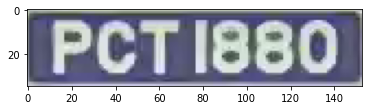

Plate is vertical: False
Plate is on black background: True


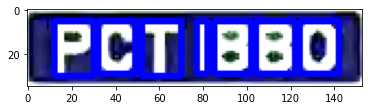

Original


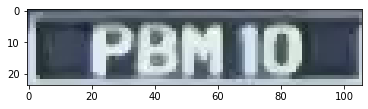

Plate is vertical: False
Plate is on black background: True


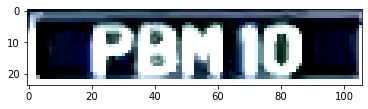

Original


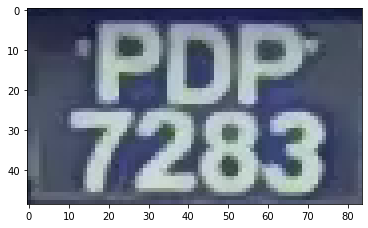

Plate is vertical: True
Plate is on black background: True


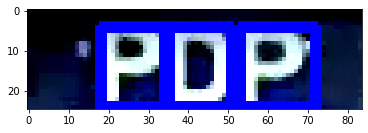

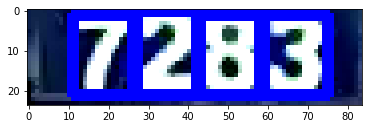

Original


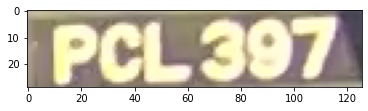

Plate is vertical: False
Plate is on black background: True


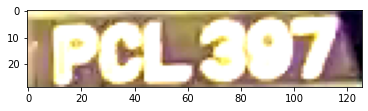

Original


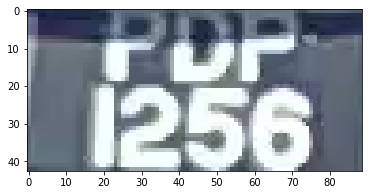

Plate is vertical: False
Plate is on black background: True


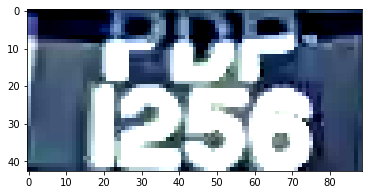

Original


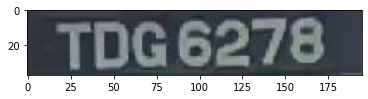

Plate is vertical: False
Plate is on black background: True


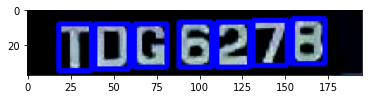

Original


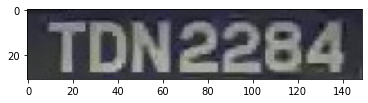

Plate is vertical: False
Plate is on black background: True


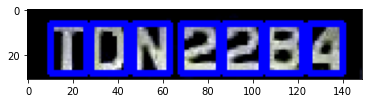

Original


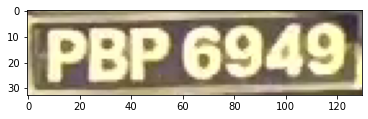

Plate is vertical: False
Plate is on black background: True


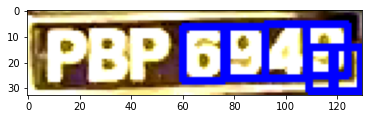

Original


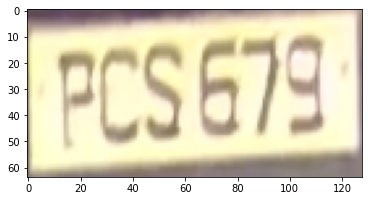

Plate is vertical: False
Plate is on black background: True
Contour too big. Crop it


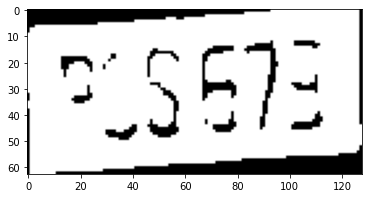

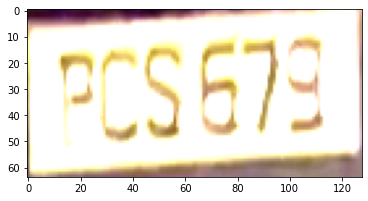

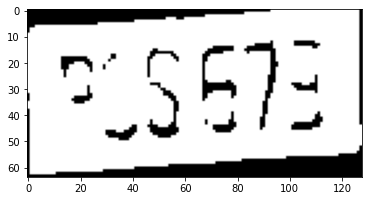

Original


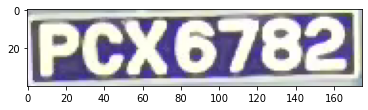

Plate is vertical: False
Plate is on black background: False
Contour too big. Crop it


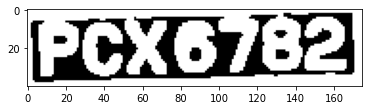

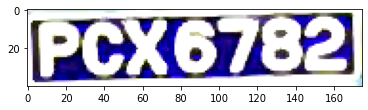

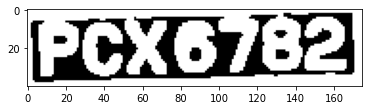

Original


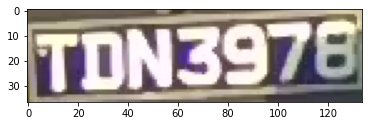

Plate is vertical: False
Plate is on black background: True


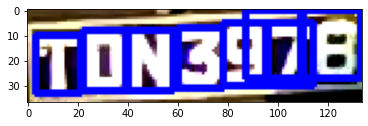

Original


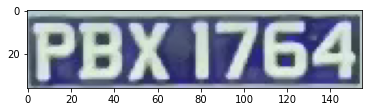

Plate is vertical: False
Plate is on black background: True


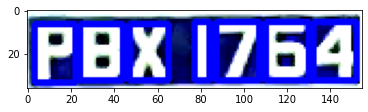

Original


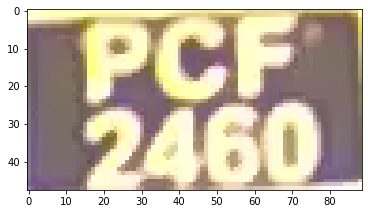

Plate is vertical: True
Plate is on black background: True


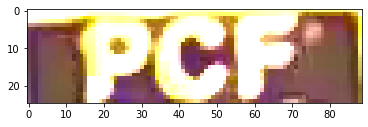

Contour too big. Crop it


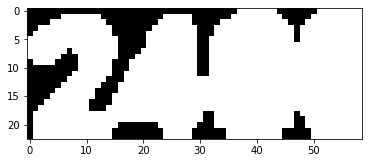

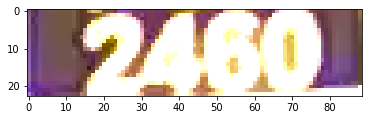

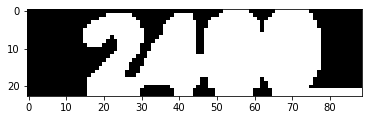

In [4]:
debug = False 

for (i,file_name) in enumerate(all_images):
    if i == 20:
        break
    #file_name = './FINAL_PLATES/HCZ5792_4b719878e237e342cb8656ca90c4b773.jpg'
    #file_name = './FINAL_PLATES/HBL3845_11fd5c969778278593b33708cf429617.png'
    #file_name = './FINAL_PLATES/HBX4175_6aa21c9dd8ea446230cce7a830be72fa.png'
    #file_name = './FINAL_PLATES/HBX7946_101c3b4d7fbc03cb6410f45d4411a945.jpg'
    #file_name = './FINAL_PLATES/PBC6948_c48e574684f82d172dec62013753d2ef.png'

    image = cv2.imread(file_name)

    imshow(image,"Original")
    vertical = isPlateVertical(image)
    blackgrnd = isBackgroundBlack(image)
    image = apply_brightness_contrast(image, contrast = 50)
    print('Plate is vertical: {}'.format(vertical))
    print('Plate is on black background: {}'.format(blackgrnd))

    if vertical:
        split = splitPlate(image)
    else:
        split = []
        split.append(image)

    for image in split:
        #image = cv2.resize(image,None,fx=2,fy=2)
        width = image.shape[0]
        height = image.shape[1]
        im_area = width * height

        org = image.copy()
        #print("Original Image")
        #plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
        #plt.show()

        contours, all_area, th, image = pre_process(image)

        if len(contours) < 3 and all_area[0] > (0.5 * im_area):
            print("Contour too big. Crop it")
            x,y,w,h = cv2.boundingRect(contours[0])
            im1 = image[y:h, x:w]
            plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
            plt.show()
            plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
            plt.show()
            contours, all_area, org, im1 = pre_process(image)
        
        if debug:
            print(all_area)

        bounding_boxes = []
        original_numbers = []
        min_digit_area = 0.01 * im_area
        max_digit_area = 0.25 * im_area


        for cnt in contours:
            area = cv2.contourArea(cnt)
            #print("Area = " + str(area))
            if (area > min_digit_area and area < max_digit_area):
                x,y,w,h = cv2.boundingRect(cnt)
                ratio = (w*1.0) / (h*1.0)
                #print("Ratio = " + str(ratio))

                if ratio > 0.15 and ratio < 1:
                    bounding_boxes.append([x,y,x+w,y+h])
                    #print(x,y,w,h)

                #cropped = image[start_row:end_row , start_col:end_col]

                if ratio > 1.2 and ratio < 2: # If 2 digits merged
                    #Crop first digit
                    x2, y2, w2, h2 = x, y, (w/2) - 1, h
                    x2, y2, w2, h2 = int(x2), int(y2), int(w2), int(h2)
                    x1, y1, w1, h1 = ((x+ w/2)), y, (w/2), h  #Crop second digit
                    x1, y1, w1, h1 = int(x1), int(y1), int(w1), int(h1)
                    #cv2.rectangle(imc,(x1,y1),(x1+w1,y1+h1),(255,0,0),2)
                    #cv2.rectangle(imc,(x2,y2),(x2+w2,y2+h2),(255,120,0),2)    
                    bounding_boxes.append([x2,y2,x2+w2,y2+h2])
                    bounding_boxes.append([x1,y1,x1+w1,y1+h1])
                    #bounding_boxes.append([x,y,x+w,y+h])
        #print(bounding_boxes)

        for i in range(len(bounding_boxes)):
            x, y, w1, h1 = bounding_boxes[i]
            original = image[y:h1, x:w1]
            #print(original)
            original_numbers.append(original)
            cv2.rectangle(org,(x,y),(w1,h1),(255,0,0),2)
            #imshow(org)

        plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
        plt.show()  

        for im in original_numbers:
            #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            #ret, roi = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
            _, roi = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            roi = makeSquare(roi)
            roi = resize_to_pixel(28, roi)
            _, roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            #plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            #plt.show()

Original


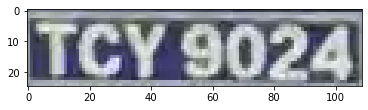

Plate is vertical: False
Plate is on black background: True


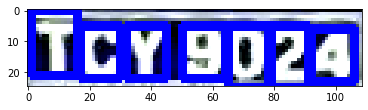

Original


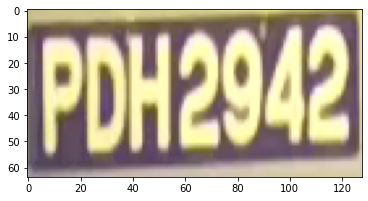

Plate is vertical: False
Plate is on black background: True


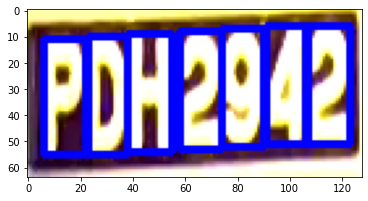

Original


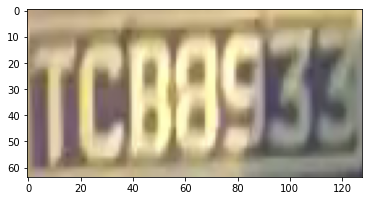

Plate is vertical: False
Plate is on black background: True


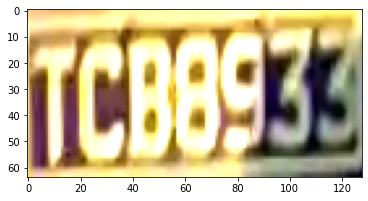

Original


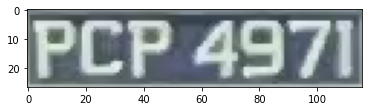

Plate is vertical: False
Plate is on black background: True


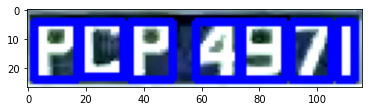

Original


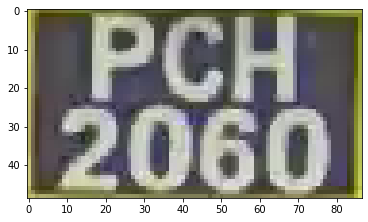

Plate is vertical: True
Plate is on black background: True


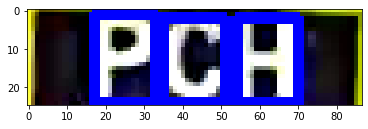

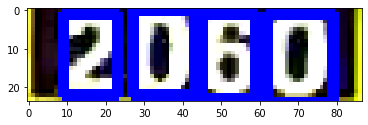

Original


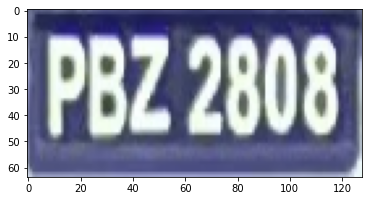

Plate is vertical: False
Plate is on black background: True


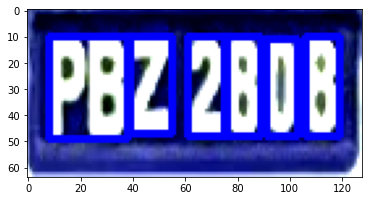

Original


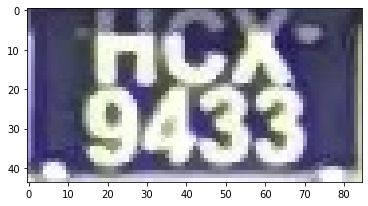

Plate is vertical: True
Plate is on black background: True


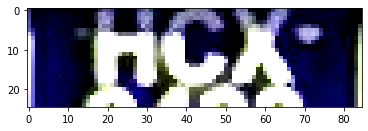

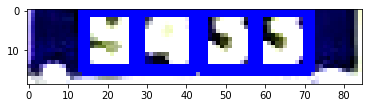

Original


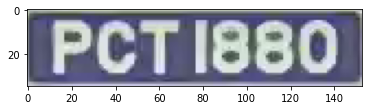

Plate is vertical: False
Plate is on black background: True


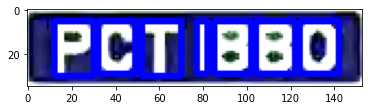

Original


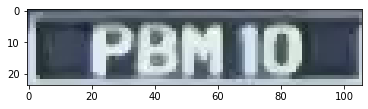

Plate is vertical: False
Plate is on black background: True


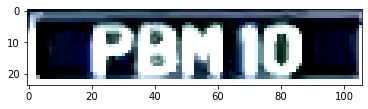

Original


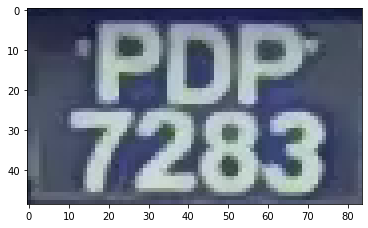

Plate is vertical: True
Plate is on black background: True


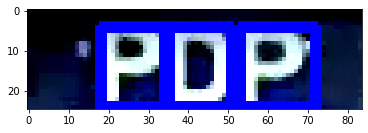

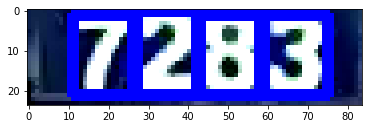

Original


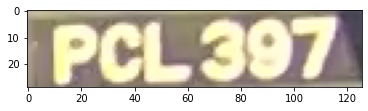

Plate is vertical: False
Plate is on black background: True


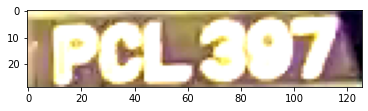

Original


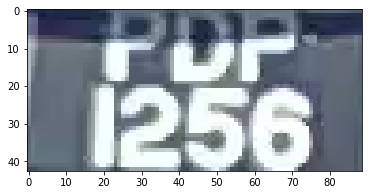

Plate is vertical: False
Plate is on black background: True


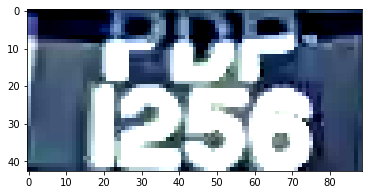

Original


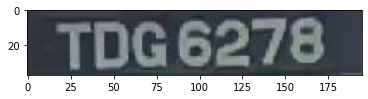

Plate is vertical: False
Plate is on black background: True


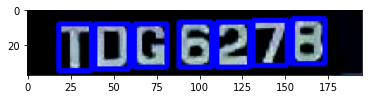

Original


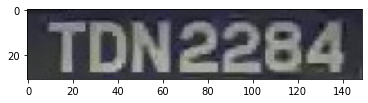

Plate is vertical: False
Plate is on black background: True


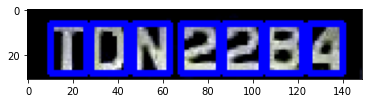

Original


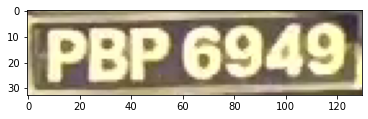

Plate is vertical: False
Plate is on black background: True


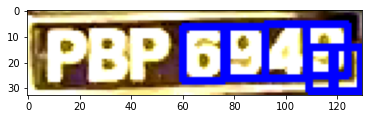

Original


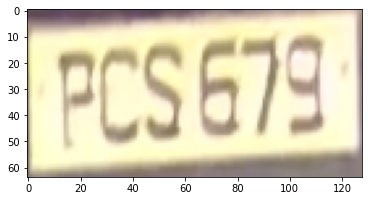

Plate is vertical: False
Plate is on black background: True
Contour too big. Crop it


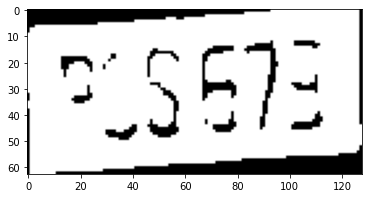

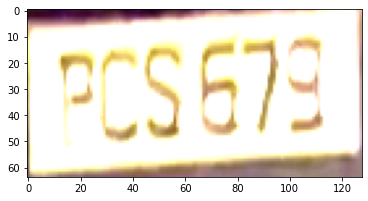

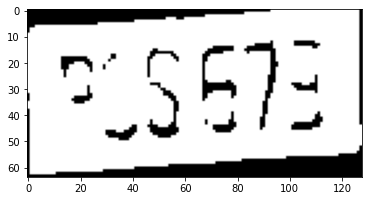

Original


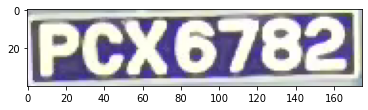

Plate is vertical: False
Plate is on black background: False
Contour too big. Crop it


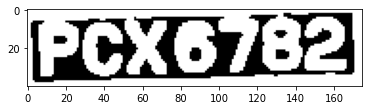

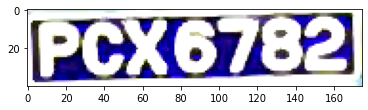

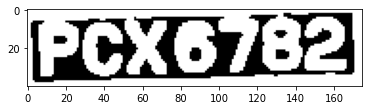

Original


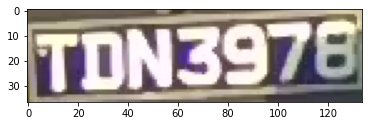

Plate is vertical: False
Plate is on black background: True


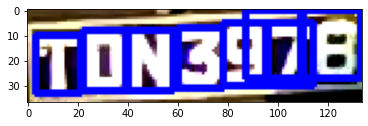

Original


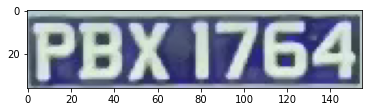

Plate is vertical: False
Plate is on black background: True


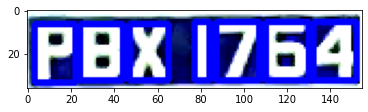

Original


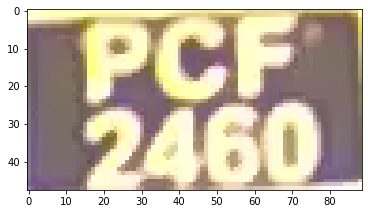

Plate is vertical: True
Plate is on black background: True


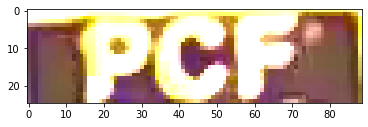

Contour too big. Crop it


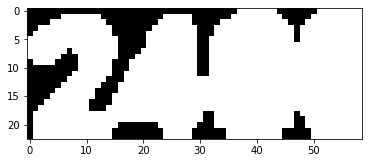

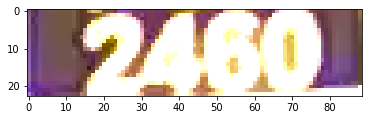

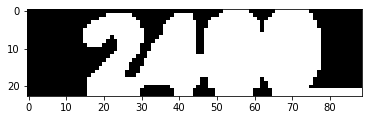

In [44]:
debug = False 

for (i,file_name) in enumerate(all_images):
    if i == 20:
        break
    #file_name = './FINAL_PLATES/HCZ5792_4b719878e237e342cb8656ca90c4b773.jpg'
    #file_name = './FINAL_PLATES/HBL3845_11fd5c969778278593b33708cf429617.png'
    #file_name = './FINAL_PLATES/HBX4175_6aa21c9dd8ea446230cce7a830be72fa.png'
    #file_name = './FINAL_PLATES/HBX7946_101c3b4d7fbc03cb6410f45d4411a945.jpg'
    #file_name = './FINAL_PLATES/PBC6948_c48e574684f82d172dec62013753d2ef.png'

    image = cv2.imread(file_name)

    imshow(image,"Original")
    vertical = isPlateVertical(image)
    blackgrnd = isBackgroundBlack(image)
    image = apply_brightness_contrast(image, contrast = 50)
    print('Plate is vertical: {}'.format(vertical))
    print('Plate is on black background: {}'.format(blackgrnd))

    if vertical:
        split = splitPlate(image)
    else:
        split = []
        split.append(image)

    for image in split:
        #image = cv2.resize(image,None,fx=2,fy=2)
        width = image.shape[0]
        height = image.shape[1]
        im_area = width * height

        org = image.copy()
        #print("Original Image")
        #plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
        #plt.show()

        contours, all_area, th, image = pre_process(image)

        if len(contours) < 3 and all_area[0] > (0.5 * im_area):
            print("Contour too big. Crop it")
            x,y,w,h = cv2.boundingRect(contours[0])
            im1 = image[y:h, x:w]
            plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
            plt.show()
            plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
            plt.show()
            contours, all_area, org, im1 = pre_process(image)
        
        if debug:
            print(all_area)

        bounding_boxes = []
        original_numbers = []
        min_digit_area = 0.01 * im_area
        max_digit_area = 0.25 * im_area


        for cnt in contours:
            area = cv2.contourArea(cnt)
            #print("Area = " + str(area))
            if (area > min_digit_area and area < max_digit_area):
                x,y,w,h = cv2.boundingRect(cnt)
                ratio = (w*1.0) / (h*1.0)
                #print("Ratio = " + str(ratio))

                if ratio > 0.15 and ratio < 1:
                    bounding_boxes.append([x,y,x+w,y+h])
                    #print(x,y,w,h)

                #cropped = image[start_row:end_row , start_col:end_col]

                if ratio > 1.2 and ratio < 2: # If 2 digits merged
                    #Crop first digit
                    x2, y2, w2, h2 = x, y, (w/2) - 1, h
                    x2, y2, w2, h2 = int(x2), int(y2), int(w2), int(h2)
                    x1, y1, w1, h1 = ((x+ w/2)), y, (w/2), h  #Crop second digit
                    x1, y1, w1, h1 = int(x1), int(y1), int(w1), int(h1)
                    #cv2.rectangle(imc,(x1,y1),(x1+w1,y1+h1),(255,0,0),2)
                    #cv2.rectangle(imc,(x2,y2),(x2+w2,y2+h2),(255,120,0),2)    
                    bounding_boxes.append([x2,y2,x2+w2,y2+h2])
                    bounding_boxes.append([x1,y1,x1+w1,y1+h1])
                    #bounding_boxes.append([x,y,x+w,y+h])
        #print(bounding_boxes)

        for i in range(len(bounding_boxes)):
            x, y, w1, h1 = bounding_boxes[i]
            original = image[y:h1, x:w1]
            #print(original)
            original_numbers.append(original)
            cv2.rectangle(org,(x,y),(w1,h1),(255,0,0),2)
            #imshow(org)

        plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
        plt.show()  

        for im in original_numbers:
            #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            #ret, roi = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
            _, roi = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            roi = makeSquare(roi)
            roi = resize_to_pixel(28, roi)
            _, roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            #plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            #plt.show()

In [ ]:
debug = False 

for (i,file_name) in enumerate(all_images):
    if i == 20:
        break
    #file_name = './FINAL_PLATES/HCZ5792_4b719878e237e342cb8656ca90c4b773.jpg'
    #file_name = './FINAL_PLATES/HBL3845_11fd5c969778278593b33708cf429617.png'
    #file_name = './FINAL_PLATES/HBX4175_6aa21c9dd8ea446230cce7a830be72fa.png'
    #file_name = './FINAL_PLATES/HBX7946_101c3b4d7fbc03cb6410f45d4411a945.jpg'
    #file_name = './FINAL_PLATES/PBC6948_c48e574684f82d172dec62013753d2ef.png'

    image = cv2.imread(file_name)

    imshow(image,"Original")
    vertical = isPlateVertical(image)